# Predicting Traffic Collision Severities in Seattle City
This is the Applied Data Science Capstone.
To study, analyze, and predict the traffic collision severities in Seattle city. 
****

In this notebook I try to predict Seattle traffic collision severities in categories 1 or 2 using a set of features that may impact the target value. 

I load the Collisions sample data using Pandas library, and apply the following models, and find the best one for this specific dataset by accuracy evaluation methods.

First load required libraries:

In [35]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

From metadata description, I learned that this dataset is about all types of past collisions in Seattle city. Collisions are displayed at the intersection or mid-block or alley, and this information is stored in the "ADDRTYPE" column. Timeframe: 2004 to Present.

The data is updated weekly and is prepared and owned by SDOT Traffic Management Division, Traffic Records Group.

## Load Data From CSV File

In [36]:
file_path = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df = pd.read_csv(file_path)
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [37]:
df.shape

(194673, 38)

So the dataset consists of 194,673 records of incidents. Each row represents a record that can be identified by "OBJECTID", the ESRI unique identifier, and for each record, the incident is documented with 38 features.

## Data Visualization and Pre-Processing

In this section, I prepared data for the next stage in the data science methodology, which is modeling. This stage involves exploring the data further and making sure that it is in the right format for the machine learning algorithm that I selected in the analytic approach stage.

After initial data examination, it is clear that collision severities are categorized as a number and are stored in "SEVERITYCODE" column.

From the metadata, we learned that:

* 2—injury
* 1—prop damage

This is confirmed by the description in "SEVERITYDESC" column. 

In [38]:
#See how many records of each class in the dataset
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

It appears that 136,485 records are associated with property damage only and 58,188 records are associated with injury.

Then I took a closer look at other columns. First thing I did was to convert the "INCDATE" and "INCDTTM" columns to Data Time Object using pandas library.

In [39]:
df['INCDATE'] = pd.to_datetime(df['INCDATE'])
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


Next, I examined the collision address type. 

In [40]:
df['ADDRTYPE'].value_counts()

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

Looks like majority of collions happen at blocks and intersections, only 751 out of 194,673 records of collions happened in alleys. This is intuitive and understandable. To avoid bias, I decided to drop Alley records.  

In [41]:
df.drop(df.loc[df['ADDRTYPE']=='Alley'].index, inplace=True)
df['ADDRTYPE'].value_counts()

Block           126926
Intersection     65070
Name: ADDRTYPE, dtype: int64

In [42]:
df.shape

(193922, 38)

From the metadata file, I learned that "UNDERINFL" column tells us whether or not a driver involved was under the influence of drugs or alcohol. I took a closer look at this column. 

In [43]:
df['UNDERINFL'].value_counts()

N    99977
0    79985
Y     5110
1     3970
Name: UNDERINFL, dtype: int64

Convert all Yes's to 1's and the No's to 0's

In [44]:
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace="Y", value=1)
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace="N", value=0)
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace="1", value=1)
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace="0", value=0)
df['UNDERINFL'].value_counts()

0.0    179962
1.0      9080
Name: UNDERINFL, dtype: int64

Next I looked at "WEATHER", "ROADCOND", and "LIGHTCOND". These columns tell us the weather conditions, road conditions, and light conditions during the time of the collision. 

In [45]:
df['WEATHER'].value_counts()

Clear                       110703
Raining                      33056
Overcast                     27616
Unknown                      14983
Snowing                        905
Other                          821
Fog/Smog/Smoke                 566
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [46]:
df['ROADCOND'].value_counts()

Dry               124020
Wet                47341
Unknown            14971
Ice                 1205
Snow/Slush          1002
Other                132
Standing Water       115
Sand/Mud/Dirt         67
Oil                   64
Name: ROADCOND, dtype: int64

In [47]:
df['LIGHTCOND'].value_counts()

Daylight                    115754
Dark - Street Lights On      48342
Unknown                      13370
Dusk                          5883
Dawn                          2494
Dark - No Street Lights       1486
Dark - Street Lights Off      1184
Other                          234
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

### Pre-processing: Feature Selection / Extraction

In order to select features that may impact collison severity code, first I looked at which day of the week traffic collisions tend to be more severe.

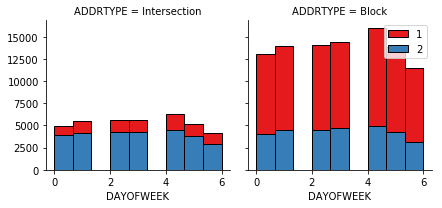

In [48]:
df['DAYOFWEEK'] = df['INCDATE'].dt.dayofweek

bins = np.linspace(df.DAYOFWEEK.min(), df.DAYOFWEEK.max(), 10)
g = sns.FacetGrid(df, col="ADDRTYPE", hue="SEVERITYCODE", palette="Set1", col_wrap=3)
g.map(plt.hist, 'DAYOFWEEK', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

It seems that compred to week days, on weekend, more records are associated with severy code "1" (i.e. property damage only), which means that which day people travel does have an impact on collision severity. Thus, I used Feature binarization to set a threshold values less then day 4.

In [49]:
df['WEEKEND'] = df['DAYOFWEEK'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,DAYOFWEEK,WEEKEND
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,NaN,NaN,NaN,10,Entering at angle,0,0,N,2,0
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N,2,0
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N,3,0
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,NaN,NaN,NaN,23,From same direction - all others,0,0,N,4,1
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,NaN,4028032.0,NaN,10,Entering at angle,0,0,N,2,0


### Convert Categorical features to numerical values

In [50]:
df.groupby(['ADDRTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

ADDRTYPE      SEVERITYCODE
Block         1               0.762885
              2               0.237115
Intersection  1               0.572476
              2               0.427524
Name: SEVERITYCODE, dtype: float64

Looks like at Intersectioins, troughly 43% of collions are tagged as type "2" (i.e. injury) while only ~24% are tagged as "2" at Block. It is clear that the address  type (intersect vs. block) has an impact on collision severities. I converted ADDRTYPE to 1 and 2.

In [51]:
df['ADDRTYPE'].replace(to_replace=['Block','Intersection'], value=[1,2],inplace=True)
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,DAYOFWEEK,WEEKEND
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,2.0,37475.0,...,NaN,NaN,NaN,10,Entering at angle,0,0,N,2,0
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,1.0,NaN,...,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N,2,0
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,1.0,NaN,...,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N,3,0
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,1.0,NaN,...,NaN,NaN,NaN,23,From same direction - all others,0,0,N,4,1
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,2.0,34387.0,...,NaN,4028032.0,NaN,10,Entering at angle,0,0,N,2,0


Then I took a look at WEATHER, ROADCOND, and LIGHTCOND. 

In [52]:
df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.732143
                          2               0.267857
Clear                     1               0.676721
                          2               0.323279
Fog/Smog/Smoke            1               0.669611
                          2               0.330389
Other                     1               0.858709
                          2               0.141291
Overcast                  1               0.683879
                          2               0.316121
Partly Cloudy             2               0.600000
                          1               0.400000
Raining                   1               0.662270
                          2               0.337730
Severe Crosswind          1               0.720000
                          2               0.280000
Sleet/Hail/Freezing Rain  1               0.752212
                          2               0.247788
Snowing                   1               0

In [53]:
df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True)

ROADCOND        SEVERITYCODE
Dry             1               0.677447
                2               0.322553
Ice             1               0.774274
                2               0.225726
Oil             1               0.625000
                2               0.375000
Other           1               0.674242
                2               0.325758
Sand/Mud/Dirt   1               0.656716
                2               0.343284
Snow/Slush      1               0.833333
                2               0.166667
Standing Water  1               0.739130
                2               0.260870
Unknown         1               0.950104
                2               0.049896
Wet             1               0.667540
                2               0.332460
Name: SEVERITYCODE, dtype: float64

In [54]:
df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True)

LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   1               0.779946
                          2               0.220054
Dark - Street Lights Off  1               0.733108
                          2               0.266892
Dark - Street Lights On   1               0.700902
                          2               0.299098
Dark - Unknown Lighting   1               0.636364
                          2               0.363636
Dawn                      1               0.670008
                          2               0.329992
Daylight                  1               0.667450
                          2               0.332550
Dusk                      1               0.670406
                          2               0.329594
Other                     1               0.777778
                          2               0.222222
Unknown                   1               0.954824
                          2               0.045176
Name: SEVERITYCODE, dtype: float64

Looks like WEATHER, ROADCOND, and LIGHTCOND have an impact on collision severities as well. They should be converted into binary values. 

In [55]:
df[['WEEKEND','ADDRTYPE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND']].head()

,WEEKEND,ADDRTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
0,0,2.0,0.0,Overcast,Wet,Daylight
1,0,1.0,0.0,Raining,Wet,Dark - Street Lights On
2,0,1.0,0.0,Overcast,Dry,Daylight
3,1,1.0,0.0,Clear,Dry,Daylight
4,0,2.0,0.0,Raining,Wet,Daylight


Use one hot encoding technique to convert categorical variables to binary variables and append them to the Feature Data Frame

In [56]:
Feature = df[['WEEKEND','ADDRTYPE','UNDERINFL']]
Feature = pd.concat([Feature,pd.get_dummies(df['WEATHER'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(df['ROADCOND'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(df['LIGHTCOND'])], axis=1)
Feature.head()

,WEEKEND,ADDRTYPE,UNDERINFL,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Other,Overcast,Partly Cloudy,Raining,...,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other,Unknown
0,0,2.0,0.0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,1.0,0.0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
2,0,1.0,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,2.0,0.0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


To further clean up the dataset, I dropped "unknown" and "other" flags. 

Check to see if there is any NAN values in the Feature dataframe as well as in the target attribute "SEVERITYCODE". If so, remove the rows that contain NAN.

In [57]:
df_clean = Feature
df_clean['SEVERITYCODE']=df['SEVERITYCODE']
df_clean.shape

(193922, 33)

In [58]:
df_clean.dropna(axis=0,inplace=True)
df_clean.isnull().sum().sum()

0

In [59]:
df_clean.shape

(187223, 33)

In [60]:
df_clean.drop(['Unknown','Other'], axis = 1,inplace=True)
df_clean.head()

,WEEKEND,ADDRTYPE,UNDERINFL,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Overcast,Partly Cloudy,Raining,Severe Crosswind,...,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,SEVERITYCODE
0,0,2.0,0.0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,2
1,0,1.0,0.0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
2,0,1.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1,1.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,2.0,0.0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,2


### Feature Selection

In [61]:
X = df_clean.loc[:, df_clean.columns != 'SEVERITYCODE']
X[0:5]

,WEEKEND,ADDRTYPE,UNDERINFL,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Overcast,Partly Cloudy,Raining,Severe Crosswind,...,Snow/Slush,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk
0,0,2.0,0.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,1.0,0.0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,0,1.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1.0,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,2.0,0.0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0


In [62]:
y = df_clean['SEVERITYCODE'].values
y[0:5]

array([2, 1, 1, 1, 2])

### Normalize Data

The next step is Data Standardization, which gives data zero mean and unit variance.

In [63]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[-0.85232892,  1.39486802, -0.22537376, -0.01634419, -1.19605691,
        -0.05477279,  2.41072122, -0.00516787, -0.46185187, -0.01155632,
        -0.0244658 , -0.06950051, -1.39140303, -0.08004708, -0.01849203,
        -0.01877885, -0.07309523, -0.02435626,  1.72369726, -0.08917241,
        -0.07950461, -0.58829036, -0.00766531, -0.11593322,  0.79172195,
        -0.17938783],
       [-0.85232892, -0.71691371, -0.22537376, -0.01634419, -1.19605691,
        -0.05477279, -0.41481362, -0.00516787,  2.16519638, -0.01155632,
        -0.0244658 , -0.06950051, -1.39140303, -0.08004708, -0.01849203,
        -0.01877885, -0.07309523, -0.02435626,  1.72369726, -0.08917241,
        -0.07950461,  1.69984088, -0.00766531, -0.11593322, -1.26306969,
        -0.17938783],
       [-0.85232892, -0.71691371, -0.22537376, -0.01634419, -1.19605691,
        -0.05477279,  2.41072122, -0.00516787, -0.46185187, -0.01155632,
        -0.0244658 , -0.06950051,  0.71869903, -0.08004708, -0.01849203,
       

## Classification

Now, it is time to split the data into training and testing set and use the training set to build an accurate model. 

Since my goal is to predict collision severities given the selected features, I need to build a predictive model. Algorithms considered:

* K Nearest Neighbor(KNN)

* Decision Tree

* Support Vector Machine

* Logistic Regression

### Train Test Split

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (149778, 26) (149778,)
Test set: (37445, 26) (37445,)


### K Nearest Neighbor (KNN)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    knn_model = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    knn_pred = knn_model.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, knn_pred)

    
    std_acc[n-1]=np.std(knn_pred==y_test)/np.sqrt(knn_pred.shape[0])

mean_acc

In [ ]:
print( "For KNN model, the best accuracy is", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [ ]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Number of K')
plt.tight_layout()
plt.show()

In [41]:
k=8
knn_best_k = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
knn_pred_best_k = knn_best_k.predict(X_test)

### Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_train,y_train)

tree_pred = tree.predict(X_test)

### Support Vector Machine

In [ ]:
from sklearn import svm

svm_model = svm.SVC().fit(X_train, y_train) 

svm_pred = svm_model.predict(X_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

logistic_model = LogisticRegression(C=0.01,solver='liblinear').fit(X_train,y_train)
logistic_pred = logistic_model.predict(X_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Model Evaluation

In [20]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Jaccard Index

In [46]:
print("The KNN model's Jaccard index is %.4f" % jaccard_similarity_score(y_test, knn_pred_best_k))
print("The Decision Tree model's Jaccard index is %.4f" %jaccard_similarity_score(y_test, tree_pred))
print("The SVM model's Jaccard index is %.4f" % jaccard_similarity_score(y_test, svm_pred))
print("The Logistic Regression model's Jaccard index is %.4f" % jaccard_similarity_score(y_test, logistic_pred))

The KNN model's Jaccard index is 0.6522
The Decision Tree model's Jaccard index is 0.6967
The SVM model's Jaccard index is 0.6967
The Logistic Regression model's Jaccard index is 0.6964


### F1-score

In [47]:
print("The KNN model's F1-score is %.4f" % f1_score(y_test, knn_pred_best_k, average='weighted'))
print("The Decision Tree model's F1-score is %.4f" %f1_score(y_test, tree_pred, average='weighted'))
print("The SVM model's F1-score is %.4f" % f1_score(y_test, svm_pred, average='weighted'))
print("The Logistic Regression model's F1-score is %.4f" % f1_score(y_test, logistic_pred, average='weighted'))

The KNN model's F1-score is 0.6226
The Decision Tree model's F1-score is 0.5791
The SVM model's F1-score is 0.5791
The Logistic Regression model's F1-score is 0.5821


### Log Loss

In [33]:
print("The Logistic Regression model's LogLoss is %.4f" % log_loss(y_test, logistic_pred))

The Logistic Regression model's LogLoss is 24.0610


### Confusion Matrix

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

#### K Nearest Neighbor

Confusion matrix, without normalization
[[21847  4238]
 [ 8786  2574]]


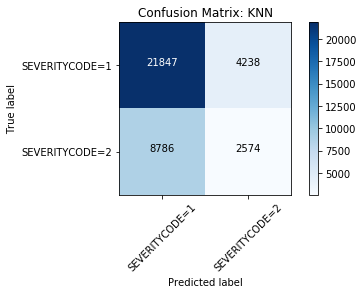

In [51]:
# Compute confusion matrix
knn_matrix = confusion_matrix(y_test, knn_pred_best_k)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(knn_matrix, classes=['SEVERITYCODE=1','SEVERITYCODE=2'],normalize= False,  title='Confusion Matrix: KNN')

#### Decision Tree

Confusion matrix, without normalization
[[25944   141]
 [11215   145]]


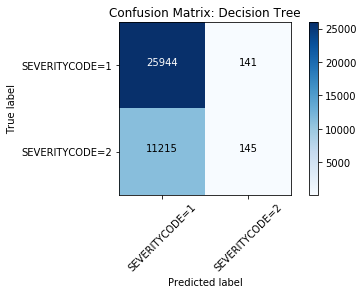

In [52]:
# Compute confusion matrix
tree_matrix = confusion_matrix(y_test, tree_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(tree_matrix, classes=['SEVERITYCODE=1','SEVERITYCODE=2'],normalize= False,  title='Confusion Matrix: Decision Tree')

#### Support Vector Machine

Confusion matrix, without normalization
[[25943   142]
 [11215   145]]


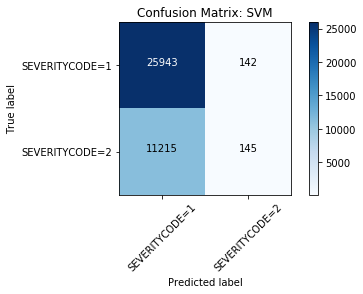

In [53]:
# Compute confusion matrix
svm_matrix = confusion_matrix(y_test, svm_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(svm_matrix, classes=['SEVERITYCODE=1','SEVERITYCODE=2'],normalize= False,  title='Confusion Matrix: SVM')

#### Logistic Regression

Confusion matrix, without normalization
[[25865   220]
 [11147   213]]


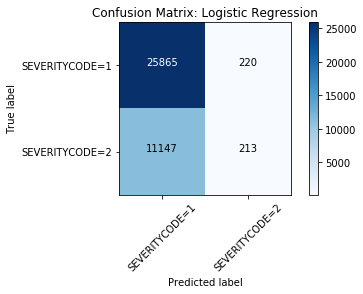

In [54]:
# Compute confusion matrix
logistic_matrix = confusion_matrix(y_test, logistic_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(logistic_matrix, classes=['SEVERITYCODE=1','SEVERITYCODE=2'],normalize= False,  title='Confusion Matrix: Logistic Regression')